# georef.ipynb

This Jupyter notebook replaces **georef.py**.

Can be run from the console using papermill:

```
papermill georef.ipynb \
          georef_output_20201211_134207.ipynb \
          -p video_path /home/aubreytensor1/Guam02/rawdata/20201211_134207.mp4 \
          -p db_path /home/aubreytensor1/Guam02/map/Guam02.db
```

### Modifications by Aubrey Moore
* 2021-01-02 frame_number now zero based
* 2021-01-03 Now works on a single video file
* 2021-01-23 Added section "Delete all records for video_id in the frames table"
* 2021-01-23 Added section "Slice dfgps so that is contains data between start_time and stop_time"

### tracks Table Schema

```sql
DROP TABLE IF EXISTS tracks;

CREATE TABLE tracks (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL UNIQUE,
    FOREIGN KEY(name) REFERENCES videos(name));

SELECT AddGeometryColumn('tracks', 'geometry', 3857, 'LINESTRING', 'XY');
```

### frames Table Schema

```sql
CREATE TABLE frames (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    video_id INTEGER,
    frame_number INTEGER NOT Null,
    time TEXT,
    geometry,
    FOREIGN KEY(video_id) REFERENCES videos(id),
    UNIQUE(video_id, frame_number)
);

SELECT RecoverGeometryColumn('frames', 'geometry', 3857, 'POINT', 'XY');
```

In [50]:
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

import glob
import logging
import spatialite
import os
from datetime import datetime, timedelta
import pandas as pd
import cv2
import plac
import re
import papermill

In [51]:
# This cell is tagged with "parameters"

#video_path = '/home/aubreytensor1/Guam02/rawdata/20201222_140644.mp4'
#db_path = '/home/aubreytensor1/Guam02/map/Guam02.db' # for testing

video_path = '/home/aubrey/Documents/roadside/rawdata/20210427_104527.mp4'
db_path = '/home/aubrey/Documents/roadside/output/spatialite.db'

In [52]:
name = os.path.basename(video_path)

In [53]:
def get_video_start_stop(video_path, cursor):
    """
    Get the video start and stop times from the exif field in the videos database table
    """
    filename = os.path.basename(video_path)
    sql = '''
        SELECT
            JSON_EXTRACT(exif, "$.QuickTime:CreateDate") AS start_time_utc,
            JSON_EXTRACT(exif, "$.QuickTime:Duration") AS duration
        FROM videos
        WHERE name = (?);
        '''
    cursor.execute(sql, [filename])
    createDate, duration = cursor.fetchone()
    # print(f'CreateDate: {createDate}, Duration: {duration}')
    createDate = datetime.strptime(createDate, '%Y:%m:%d %H:%M:%S')
    start = createDate - timedelta(seconds=duration)
    stop = createDate
    logging.info(f'Start: {start}   Stop:  {stop} UTC')
    return start, stop

In [54]:
def get_lat_lon(timestamp, dfgps):
    timestamp = pd.to_datetime(timestamp)
    df = dfgps[dfgps.time==timestamp]
    if not df.empty:
        # There is a record for exact timestamp (unlikely); return lat lon.
        return dfgps.lat.values[0], dfgps.lon.values[0]
    else:
        # Estimate lat lon using linear interpolation records just prior and post timestamp
        df1 = dfgps[dfgps.time<timestamp].tail(1)
        df2 = dfgps[dfgps.time>timestamp].head(1)
        t1 = df1.time.values[0]
        t2 = df2.time.values[0]
        lat1 = df1.lat.values[0]
        lat2 = df2.lat.values[0]
        lon1 = df1.lon.values[0]
        lon2 = df2.lon.values[0]
        fraction = (timestamp-t1)/(t2-t1)
        lat = lat1 + fraction*(lat2-lat1)
        lon = lon1 + fraction*(lon2-lon1)
        return lat, lon

In [55]:
def populate_frames_table(video_path, db_path):
    """
    Populates the frames table in the survey database.
    Columns are: frame_number, timestamp (UTC), lat, lon
    """
    FRAME_INTERVAL = 1000 # Sets frequency for logging

    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s [%(levelname)s] %(funcName)s %(message)s",
        datefmt="%Y-%m-%dT%H:%M:%S%z",
        handlers=[logging.StreamHandler()])
    logging.info('Starting georef.py')

    # Connect database
    conn = spatialite.connect(db_path)
    cursor = conn.cursor()

    # Find the GPS log file
    gpslogpath = re.sub(r'_\d{6}.mp4', '.csv', video_path, 0, re.MULTILINE)
    logging.info(f'gpslogpath = {gpslogpath}')

    # Load the gps log file csv into a dataframe
    logging.info(f'Reading GPS log from {gpslogpath}')
    dfgps = pd.read_csv(gpslogpath, parse_dates=['time'])
    dfgps['time'] = dfgps['time'].dt.tz_localize(None)
    
    print(dfgps)

    # Slice dfgps so that is contains data between start_time-10s and stop_time+10s
    start_time, stop_time = get_video_start_stop(video_path, cursor)
    pd.set_option('display.max_columns', None)
    logging.info(f'dfgps prior to slicing: {dfgps.time.iloc[0]}   {dfgps.time.iloc[-1]} UTC')
    dfgps = dfgps[ dfgps.time.between(start_time-timedelta(0,10), stop_time+timedelta(0,10)) ]
    logging.info(f'dfgps after slicing:    {dfgps.time.iloc[0]}   {dfgps.time.iloc[-1]} UTC')

    gpslog_start_time = dfgps.time.min().to_pydatetime()
    gpslog_stop_time = dfgps.time.max().to_pydatetime()
    logging.info(f'dfgps after slicing:    {gpslog_start_time}   {gpslog_stop_time} UTC')

    # Get the video_id from the videos table
    video = os.path.basename(video_path)
    sql = (f'SELECT id FROM videos WHERE name = "{video}"')
    cursor.execute(sql)
    video_id = cursor.fetchone()[0]

    # Delete all records for video_id in the frames table
    sql = (f'DELETE FROM frames WHERE video_id="{video_id}";')
    cursor.execute(sql)
    conn.commit()

    # populate frames table with records for the current video
    cap = cv2.VideoCapture(video_path)
    while True:
        pos_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
        frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES)
        timestamp = start_time + timedelta(milliseconds=pos_msec)
        if (timestamp > gpslog_start_time) and (timestamp < gpslog_stop_time):
            lat, lon = get_lat_lon(timestamp, dfgps)
            geometry = f'TRANSFORM(GeomFromText("POINT({lon} {lat})", 4326), 3857)'
            sql = f'INSERT INTO frames(video_id,frame_number,time,geometry) VALUES({video_id},{frame_number},"{timestamp}",{geometry});'
            logging.debug(sql)
            cursor.execute(sql)
            conn.commit()
        else:
            logging.error(f'No gps log data available for frame {frame_number} in {video_path}')            
        if (frame_number % FRAME_INTERVAL == 0):
            logging.info(f'{frame_number} {timestamp}')
        frame_exists, _ = cap.read()
        if not frame_exists:
            break
            
    cap.release()

    # Disconnect database
    cursor.close()
    conn.close()

    return dfgps

In [56]:
# MAIN

df = populate_frames_table(video_path, db_path)

2021-04-27T13:13:50+1000 [INFO] populate_frames_table Starting georef.py
2021-04-27T13:13:50+1000 [INFO] populate_frames_table gpslogpath = /home/aubrey/Documents/roadside/rawdata/20210427.csv
2021-04-27T13:13:50+1000 [INFO] populate_frames_table Reading GPS log from /home/aubrey/Documents/roadside/rawdata/20210427.csv
2021-04-27T13:13:50+1000 [INFO] get_video_start_stop Start: 2021-04-27 00:45:28.891000   Stop:  2021-04-27 00:45:59 UTC
2021-04-27T13:13:50+1000 [INFO] populate_frames_table dfgps prior to slicing: 2021-04-27 00:13:54.348000   2021-04-27 00:46:25.999000 UTC
2021-04-27T13:13:50+1000 [INFO] populate_frames_table dfgps after slicing:    2021-04-27 00:45:18.999000   2021-04-27 00:46:04.999000 UTC
2021-04-27T13:13:50+1000 [INFO] populate_frames_table dfgps after slicing:    2021-04-27 00:45:18.999000   2021-04-27 00:46:04.999000 UTC
2021-04-27T13:13:50+1000 [INFO] populate_frames_table 0.0 2021-04-27 00:45:28.891000


                        time        lat         lon   elevation  accuracy  \
0    2021-04-27 00:13:54.348  13.413736  144.784644  200.816701      32.0   
1    2021-04-27 00:13:57.000  13.413738  144.784645  200.949818      32.0   
2    2021-04-27 00:13:58.000  13.413738  144.784646  200.947065      32.0   
3    2021-04-27 00:14:00.000  13.413739  144.784644  200.851791      32.0   
4    2021-04-27 00:14:02.000  13.413916  144.784758  173.784051      16.0   
...                      ...        ...         ...         ...       ...   
1095 2021-04-27 00:46:19.999  13.414576  144.784595  141.556775      16.0   
1096 2021-04-27 00:46:21.999  13.414558  144.784590  141.577509      24.0   
1097 2021-04-27 00:46:23.999  13.414597  144.784599  141.597440      24.0   
1098 2021-04-27 00:46:24.999  13.414601  144.784595  141.694354      24.0   
1099 2021-04-27 00:46:25.999  13.414609  144.784595  141.772051      32.0   

         bearing     speed  satellites provider  hdop  vdop  pdop  \
0     

<AxesSubplot:>

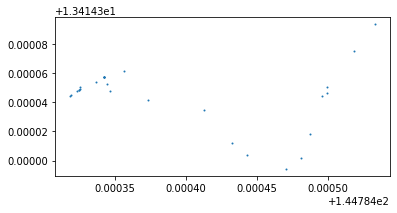

In [57]:
# Convert dataframe to a geodataframe
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
df = df.drop(['lat', 'lon'], axis=1)
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
gdf.plot(markersize=1)

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

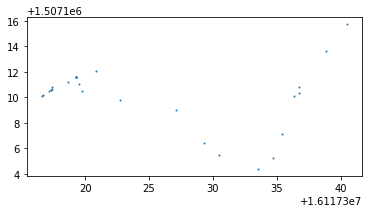

In [58]:
# Reproject geometry to UTM (meters)
gdf = gdf.to_crs('EPSG:3857')
gdf.plot(markersize=1)
gdf.crs

In [59]:
# Get the LineString
ls = LineString(gdf.geometry.to_list())
print(len(ls.coords))

28


2


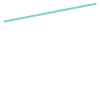

In [60]:
# Simplify the LineString
lss = ls.simplify(10)
print(len(lss.coords))
lss

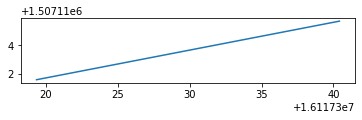

In [61]:
# Save LineString plot to file
p = gpd.GeoSeries(lss)
p.plot()
filename = name.replace('.mp4', '.png')
filename = f'track_{filename}'
plt.savefig(filename)

In [62]:
# Update the tracks table
with spatialite.connect(db_path) as db:
    sql = f"DELETE FROM tracks WHERE name='{name}';"
    print(sql)
    db.execute(sql)
    sql = f"INSERT INTO tracks VALUES(NULL, '{name}', GeomFromText('{lss.wkt}',3857));"
    print(sql)
    db.execute(sql)
    db.commit()

DELETE FROM tracks WHERE name='20210427_104527.mp4';
INSERT INTO tracks VALUES(NULL, '20210427_104527.mp4', GeomFromText('LINESTRING (16117319.29855262 1507111.603930576, 16117340.4716246 1507115.698698445)',3857));


In [63]:
print('FINISHED')

FINISHED
